In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm

In [2]:
import access_br_dwgd as access_br_dwgd

timeseries = access_br_dwgd.recuperar_dados_br_dwgd(True)

train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


Dados carregados com sucesso para a estação: 2552000
Total de 23090 dias válidos no período selecionado.


In [3]:


lookback = 5
X_train, y_train = lstm.create_dataset(train, lookback=lookback)
X_test, y_test = lstm.create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([16157, 5, 1]) torch.Size([16157, 5, 1])
torch.Size([6923, 5, 1]) torch.Size([6923, 5, 1])


/home/pbose/tcc/pesquisa/utils/lstm.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(X), torch.tensor(y)


In [4]:
model = LstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=20)

In [5]:
n_epochs = 5

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    



# --- Bloco de Avaliação Final (executado apenas uma vez) ---
print("\nTreinamento finalizado. Calculando o RMSE final...")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    y_pred_test = model(X_test)
    
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.detach().cpu().numpy().flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
print(f"Conjunto de Teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
print("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        print(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")


Treinamento finalizado. Calculando o RMSE final...
Conjunto de Teste:
RMSE: 14.7726
MSE: 218.2294
MAE: 8.0733

--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---
Exemplo 1: Previsto = [7.3671975], Esperado = [0.]
Exemplo 2: Previsto = [4.5214057], Esperado = [24.7]
Exemplo 3: Previsto = [7.376101], Esperado = [0.]
Exemplo 4: Previsto = [4.5214057], Esperado = [0.]
Exemplo 5: Previsto = [4.5214057], Esperado = [0.]
Exemplo 6: Previsto = [4.5214057], Esperado = [0.]
Exemplo 7: Previsto = [4.5214057], Esperado = [0.]
Exemplo 8: Previsto = [4.5214057], Esperado = [0.]
Exemplo 9: Previsto = [4.5214057], Esperado = [0.]
Exemplo 10: Previsto = [4.5214057], Esperado = [0.]


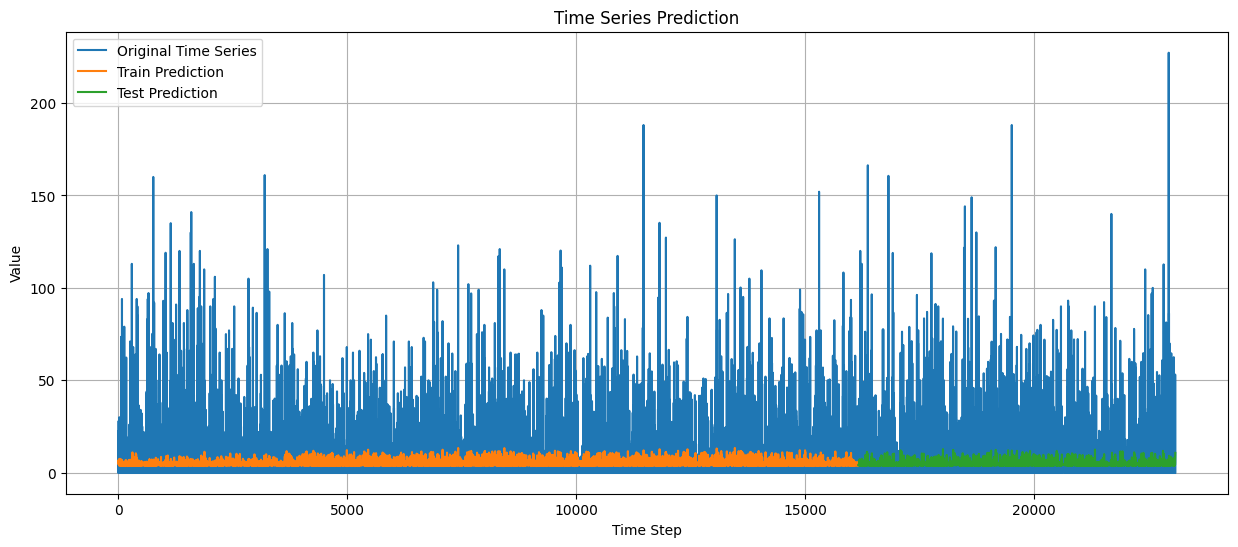

In [ ]:
model.eval()
with torch.no_grad():
    # Previsões do modelo
    #train_pred = model(X_train)[:, -1, :].squeeze().cpu().numpy()
    test_pred = model(X_test)[:, -1, :].squeeze().cpu().numpy()

# Inicializa arrays com NaN para plotar nas posições corretas
full_len = len(timeseries)
train_plot = np.full(full_len, np.nan)
test_plot = np.full(full_len, np.nan)

# Alinha previsões de treino
#train_plot[lookback:lookback + len(train_pred)] = train_pred

# Alinha previsões de teste
test_plot[train_size + lookback : train_size + lookback + len(test_pred)] = test_pred

# Plot
plt.figure(figsize=(15, 6))
plt.plot(timeseries, label='Original Time Series')
#plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.legend()
plt.title('Time Series Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()